<a href="https://colab.research.google.com/github/Xabz/c-/blob/master/writer_identification_using_twin_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import time
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
import albumentations as albu

if albu.__version__ != '1.0.3': 
    os.system('pip install -U git+https://github.com/albumentations-team/albumentations')
    print('albumentations updated\nrestart required')

!pip -q install coclust
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from coclust.evaluation.external import accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print(albu.__version__)

1.0.3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if not os.path.exists('./IAM Dataset'):
    ret = os.system("cp '/content/drive/MyDrive/Dataset/IAM.zip' '/content/IAM Handwritten.zip'")
    if ret != 0:  ret = os.system("cp '/content/drive/MyDrive/IAM.zip' '/content/IAM Handwritten.zip'")
    if ret == 0:  print("Data loaded")
    os.system("unzip -qq '/content/IAM Handwritten.zip'")

images_path = '/content/IAM Handwritten/*'
labels_path = '/content/IAM labels/*'

Data loaded


In [4]:
writer=[]
word_id={}
d={}

for filename in sorted(glob.glob(labels_path)):
    tree = ET.parse(filename)
    root = tree.getroot()
    id = root.attrib.get('writer-id')
    for i in root.iter('word'):
        #w_id = i.attrib.get('id')
        text = i.attrib.get('text')
        if len(text)>2 and len(text)<15:
            if id in d:  d[id] = d[id]+1
            else:        d[id] = 1

for filename in sorted(glob.glob(labels_path)):
    tree = ET.parse(filename)
    root = tree.getroot()
    id = root.attrib.get('writer-id')
    
    for i in root.iter('word'):
        w_id = i.attrib.get('id')
        text = i.attrib.get('text')
        if d[id]>200 and d[id]<600 and len(text)>2 and len(text)<15:
            word_id[w_id]=id

In [5]:
image_files = []
target_files = []

images = sorted(glob.glob('/content/IAM Handwritten/**/*.png', recursive=True))

for filename in sorted(tqdm(images)):
    s_filename = filename
    s_filename = s_filename.split('/')[-1]
    s_filename = s_filename.split('.')[0]

    try:
        im = Image.open(filename)
        if s_filename in word_id:
            image_files.append(filename)
            target_files.append(word_id[s_filename])
    except:
      continue

x = np.asarray(image_files)
y = np.asarray(target_files)
print(x.shape,y.shape)
print(np.unique(x).shape,np.unique(y).shape)


(35901,) (35901,)
(35901,) (114,)


In [23]:
x_train, x_val, y_train, y_val = train_test_split(x,y,train_size=0.7,random_state=52,shuffle=True)
#x_val,x_test,y_val,y_test = train_test_split(x_rem,y_rem,train_size=0.5,random_state=52,shuffle=True)

y_train = LabelEncoder().fit_transform(y_train)
y_val = LabelEncoder().fit_transform(y_val)
#y_test = LabelEncoder().fit_transform(y_test)

def resize_val(x_val,y_val,height,width):
    n = x_val.shape[0]
    X = np.zeros((x_val.shape[0],height,width,3),dtype='float32')
    y = np.zeros((y_val.shape[0]),dtype='int32')
    for i in range(0,n):
        im = read_image(x_val[i],height,width)
        y[i] = y_val[i]
        X[i,:,:,0] = im
        X[i,:,:,1] = im
        X[i,:,:,2] = im

    #X = X[:,:,:,np.newaxis]
    return X,y

def read_image(image_dir,height,width):
    im = Image.open(image_dir).resize((width,height))
    return np.array(im, dtype=np.float32)      

x_val, y_val = resize_val(x_val,y_val,60,120)

print(x_train.shape,x_val.shape)
print(y_train.shape,y_val.shape)
print(np.unique(y_train).shape,np.unique(y_val).shape)

(25130,) (10771, 60, 120, 3)
(25130,) (10771,)
(114,) (114,)


In [24]:
# class dataGenerator(tf.keras.utils.Sequence):
#     """ Recieves X and y 
#         Performes pairwise matching with a batch size 
#         both pairs are generated from the input X and y
#     """
#     def __init__(self, X, y,height,width, alpha, validation_data=None, batch_size=64):
#         self.batch_size  = batch_size                               
#         self.inputX      = X                                        
#         self.inputY      = y 
#         self.height = height   
#         self.width = width                                
#         if self.inputY.shape[-1] == 1:
#             self.inputY = self.inputY.reshape(self.inputY.shape[0])
#         self.total       = len(X)                                   
#         self.alpha       = alpha

#         self.class_index = dict([(label, list(np.where(self.inputY == label)[0])) \
#                                  for label in np.unique(self.inputY)])  
#         self.indexes     = np.arange(self.total)
#         self.total_batch = self.total // self.batch_size 
#         self.classes = len(np.unique(self.inputY))
#         self.on_epoch_end()
        
#     def __len__(self):
#         return int(self.total // self.batch_size)

#     def read_image(self, image_dir):
#         im = Image.open(image_dir).resize((self.width, self.height))
        
#         return np.array(im, dtype=np.float32)

#     def __getitem__(self, index):
#         indexes1 = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         indexes2 = np.zeros(self.batch_size, dtype=np.int32)
#         constraint = np.zeros(self.batch_size, dtype=np.int32)

#         X = np.zeros((self.batch_size,2,self.height,self.width),dtype='float32')

#         for i in range(self.batch_size):
#             label = self.inputY[indexes1[i]]
#             # Take same class-pair if True
#             if random.choices([True, False], weights=[0.5, 0.5])[0] == True:
#                 indexes2[i] = random.choice(self.class_index[label])
#             else:
#                 choice = label
#                 while label == choice:
#                     label = random.randint(0, self.classes-1)
#                 indexes2[i] = random.choice(self.class_index[label])
#                 constraint[i] = self.alpha
#             tempimg1 = self.read_image(self.inputX[indexes1[i]])
#             tempimg2 = self.read_image(self.inputX[indexes2[i]])

#             X[i,0] = tempimg1
#             X[i,1] = tempimg2

        
#         X = X[:,:,:,:,np.newaxis]
#         return [X[:,0,:,:], X[:,1,:,:]], constraint

#     def on_epoch_end(self):
#         """ Updates indexes after each epoch """
#         np.random.shuffle(self.indexes)



class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=1, validation_data=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data is not None:
            self.x_val, self.y_val = validation_data
            self.classes = len(np.unique(self.y_val))
        self.start_time = time.time()
        self.epoch = 0
        self.savelog = {'Epoch': [], 'ACC':[], 'NMI':[], 'ARI':[]}
        

    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.n is not 0: return
        self.epoch += 1

        acc, nmi, ari = self._KmeansAcc()
        ep_time = time.time() - self.start_time
        self.start_time = time.time()
        print(f"\rEpoch {self.epoch}: ACC {acc:.5f} NMI {nmi:.5f} ARI {ari:.5f} Time:{ep_time:.1f}",
              end='\n')
        self._saveLog(self.epoch, acc, nmi, ari)


    def _saveLog(self, epoch, acc, nmi, ari):        
        self.savelog['Epoch'].append(epoch)
        self.savelog['ACC'].append(acc)
        self.savelog['NMI'].append(nmi)
        self.savelog['ARI'].append(ari)
            

    def _KmeansAcc(self):
        kmeans = KMeans(n_clusters=self.classes, n_jobs=-1, n_init=10)
        AE = self.model.layers[2]
        rindex = np.random.randint(0, self.y_val.shape[0], size=2000)
        outs = AE.predict(self.x_val[rindex])
        y_pred = kmeans.fit_predict(outs)
        acc = accuracy(self.y_val[rindex], y_pred)
        nmi = normalized_mutual_info_score(self.y_val[rindex], y_pred)
        ari = adjusted_rand_score(self.y_val[rindex], y_pred)
        return (acc, nmi, ari)

In [25]:
class AEGenerator(tf.keras.utils.Sequence):
    """ Recieves X and y 
        Performes pairwise matching with a batch size 
        both pairs are generated from the input X and y
 
        imgs         : Input image directory
        y            : Pseudo label, Numpy Array, Output shape=(bs, ) or (bs, 1)
        gt           : Ground truth of the actual class, Numpy Array, Output shape=(bs, ) or (bs, 1).
        dist      : Distance parameter for AE
        noise     : Ratio of augmentation
        scale     : The maximum limit of noise that would be mixed with X
        show_logs : Show random selection errors

                    Use only when show_logs is True

        dg = AEGenerator(iX=X, iy=cy, dist=dist, noise=noise, 
                         batch_size=batch_size, scale=aug_scale, 
                         show_logs=False, gt=y, 
                         output_channel=1 if model == 'MobileNet' else 3)
        
    """
    
    def __init__(self, imgs, pseudo_label, dist, ground_label, input_shape,
                 batch_size=64, show_logs=False, prob=1.0):
        
        self.batch_size  = batch_size
        self.x = imgs
        self.py = pseudo_label
        self.gy = ground_label

        # Probability of augmentation
        self.prob = prob

        if self.py.shape[-1] == 1:
            self.py = np.squeeze(self.py)
        if self.gy.shape[-1] == 1:
            self.gy = np.squeeze(self.gy)
        
        assert len(input_shape) == 3, 'Input shape must be 3 dimentional'
        self.input_shape = input_shape

        self.total = len(self.x)
        self.dist = dist
 
        # Generates label : indexes_where_label_found
        ulabels = np.unique(self.py)
        self.class_index = dict([(label, list(np.where(self.py == label)[0])) \
                                 for label in ulabels]) 

        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size 
        self.classes = len(ulabels)
 
        self.rand = random.Random(12)
        random.seed(12)

        # Show logs
        self.show_logs = show_logs
        self.log = {}
        self.on_epoch_end()
        self.aug_func = AEGenerator.strong_aug(self.input_shape, p=self.prob)


    # Strong augmentation features
    @staticmethod
    def strong_aug(img_shape, p=1, color_augment=False):
        h = int(img_shape[0]*0.1)
        w = int(img_shape[1]*0.1)
        return albu.Compose([
            #albu.RandomRotate90(),
            #albu.Flip(),
            #albu.Transpose(),
            albu.Cutout(num_holes=12, max_h_size=h, max_w_size=w, 
                        fill_value=0, p=0.4),
            albu.OneOf([
                albu.IAAAdditiveGaussianNoise(),
                albu.GaussNoise(),
            ], p=0.7),
            #albu.OneOf([
            #    albu.MotionBlur(p=0.2),
            #    albu.MedianBlur(blur_limit=3, p=0.1),
            #    albu.Blur(blur_limit=3, p=0.1),
            #], p=0.5),
            albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, 
                                rotate_limit=20, p=0.3),
            albu.OneOf([
                albu.OpticalDistortion(p=0.3),
                albu.GridDistortion(p=0.1),
                albu.IAAPiecewiseAffine(p=0.3),
            ], p=0.5),
            albu.OneOf([
            #    albu.CLAHE(clip_limit=2),
                albu.IAASharpen(),
                albu.IAAEmboss(),
                albu.RandomBrightnessContrast(),
            ], p=0.3),
            #albu.HueSaturationValue(p=0.5),
            #albu.ChannelShuffle(p=0.5),
            #albu.RandomRain(brightness_coefficient=1, drop_width=1, 
            #                blur_value=1),
            #albu.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, 
            #               alpha_coef=0.1, p=0.3),
        ], p=p)


    @staticmethod
    def image_resize(image, width = None, height = None):
        """Img is a PIL image"""
        dim = None
        (w, h) = image.size

        if width is None and height is None:
            return None
        if width is None:
            r = height / float(h)
            dim = (int(w * r), height)
        else:
            r = width / float(w)
            dim = (width, int(h * r))

        return image.resize(dim)


    def __len__(self):
        """ Denotes the number of batches per epoch """
        return self.total_batch
 

    def _print_logs(self):
        for a, b in self.log.items():
            print(a, ':', b)
    

    def on_epoch_end(self):
        """ Updates indexes after each epoch """
        np.random.shuffle(self.indexes)
        if self.show_logs:
            self._print_logs()
            self.log['canNotLink_error'] = 0
            self.log['time'] = 0
    

    def _make_choice(self, p=None):
        w = [0.5, 0.5]
        if p is not None:
            w = [p, 1-p]
        return self.rand.choices([True, False], weights=w)[0]


    def read_image(self, image_id):
        """Reads an image from disk, given image_id
            Randomly crops the image w.r.t. input_shape
        """
        im = Image.open(self.x[image_id])
        # Resize the image w.r.t. aspect ratio
        im = AEGenerator.image_resize(im, height=self.input_shape[0])        
        im = np.asarray(im, dtype=np.uint8)
        w_pos_l = np.random.randint(low=0, high=max(im.shape[1]-self.input_shape[1]-1, 1))
        
        return im[..., w_pos_l:w_pos_l+self.input_shape[1]]

    
    def _augment(self, imgs):
        """ Inputs some image indices,
            Returns the augmented images
            Input_dim : [2*batch_size, ]
        """
        aug_imgs = np.zeros((len(imgs), ) + self.input_shape, dtype=np.uint8)

        #print('Imgs:', imgs.shape)
        for i in range(len(imgs)):
            aug_imgs[i] = self.aug_func(image=imgs[i])['image']
            # print('Augmented')
            # plt.imshow(aug_imgs[i], cmap='gray')
            # plt.show()
        
        return aug_imgs


    def __getitem__(self, batch_index):
        """ Generate one batch of data """
        idx, y = self._genIndexes(batch_index)
        #img_dirs = self.x[idx]

        # Reading the image files        
        imgs = np.ones((2*self.batch_size, ) + self.input_shape, dtype=np.uint8)
        for i in range(2*self.batch_size):
            tmp_img = self.read_image(idx[i])
            #print(tmp_img.shape, imgs[i].shape)
            imgs[i, 0:, 0:tmp_img.shape[1], 0] = tmp_img
            imgs[i, 0:, 0:tmp_img.shape[1], 1] = tmp_img
            imgs[i, 0:, 0:tmp_img.shape[1], 2] = tmp_img
            # print(imgs[i].shape)
            # plt.imshow(imgs[i], cmap='gray')
            # plt.show()

        if self.prob > 0:
            aug_idx = self.rand.sample(range(2*self.batch_size), k=self.batch_size)
            imgs[aug_idx] = self._augment(imgs[aug_idx])
        
        return [imgs[:self.batch_size], imgs[self.batch_size:]], y
    

    def _genIndexes(self, index):
        idx = np.zeros((2, self.batch_size), dtype=np.int32)
        idx[0] = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        constraint = np.zeros(self.batch_size, dtype=np.int32)
 
        for i in range(self.batch_size):
            plabel = self.py[idx[0][i]]
            take = idx[0][i]
 
            # Generating must-links
            if self._make_choice():
                take = self.rand.choice(self.class_index[plabel])
            # Generating can-not links
            else:
                # Taking random pair
                while self.py[take] == plabel:
                    take = self.rand.choice(self.indexes)
                constraint[i] = self.dist
 
                if self.show_logs and self.gy[idx[0][i]] == self.gy[take]:
                    self.log['canNotLink_error'] += 1

            idx[1][i] = take

        return idx.reshape((2*self.batch_size)), constraint

In [26]:
#dg = dataGenerator(x_train,y_train,height=60,width=120,alpha=100,batch_size=128)

#  AEGenerator: imgs, pseudo_label, dist, ground_label, input_shape, 
#               batch_size=64, show_logs=False, prob=1.0

un_dg = AEGenerator(imgs=x_train, pseudo_label=np.arange(len(y_train)),
                    dist=100, ground_label=y_train, input_shape=(40, 120, 3),
                    batch_size=64, show_logs=True)

In [ ]:
xx,yy=un_dg[0]
xx[1].shape

(8, 40, 120, 3)

In [27]:
K.clear_session()

dims=12
input_shape = (60,120,3)
alpha = 100

class Distance(tf.keras.layers.Layer):
    def __init__(self, alpha):
        super(Distance, self).__init__()
        self.activation = tf.keras.layers.ReLU(max_value=alpha)
        
    def call(self, inputs):
        dist = tf.expand_dims(tf.math.sqrt(tf.math.reduce_sum(tf.math.square(inputs[0]-inputs[1]), 
                                                              axis=1)), 
                              axis=-1)
    
        return self.activation(dist)
    

def create_layer(input_shape,dims):
    model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet')
    inp = tf.keras.Input(input_shape)
    out = tf.keras.layers.Lambda(lambda x: x/127.5 - 1)(inp)
    #out = tf.keras.layers.Concatenate(axis=-1, name='input_concat')([out, out, out])
    out = model(out)
    out = Flatten()(out)
    out = Dense(units=dims)(out)
    
    model = tf.keras.Model(inp, out, name='AE_mobilenet')
    model.summary()
    return model


def create_siamese(input_shape,dims,alpha):
    input1 = tf.keras.Input(input_shape)
    input2 = tf.keras.Input(input_shape)

    block = create_layer(input_shape, dims)
    out1 = block(input1)
    out2 = block(input2)
    out = Distance(alpha)([out1, out2])
    
    model = tf.keras.Model([input1,input2],out)
    model.compile(optimizer='adam',loss='mse')
    return model, block

model,block = create_siamese(input_shape,dims,alpha)

# tf.keras.utils.plot_model(block, 'Writer_recognizer.png', 
#                               show_shapes=True)

Model: "AE_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 60, 120, 3)]      0         
_________________________________________________________________
lambda (Lambda)              (None, 60, 120, 3)        0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                36876     
Total params: 3,265,740
Trainable params: 3,243,852
Non-trainable params: 21,888
_________________________________________________________________


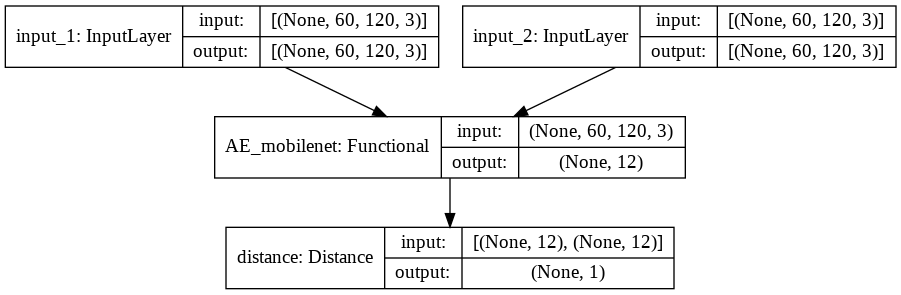

In [ ]:
tf.keras.utils.plot_model(model, 'Writer_recognizer.png', 
                         show_shapes=True)

In [28]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                 factor=0.3, patience=3, 
                                                 verbose=1)
log = MyLogger(validation_data=(x_val, y_val))

In [29]:
history=model.fit(un_dg, epochs=100, callbacks=[log,reduce_lr],
                  max_queue_size=20)

Epoch 1/100
392/392 [==============================] - 382s 966ms/step - loss: 662.0604
Epoch 1: ACC 0.15750 NMI 0.47810 ARI 0.03967 Time:388.8
canNotLink_error : 115
time : 0
Epoch 2/100
392/392 [==============================] - 373s 952ms/step - loss: 470.0179
Epoch 2: ACC 0.15750 NMI 0.47202 ARI 0.03848 Time:375.5
canNotLink_error : 138
time : 0
Epoch 3/100
392/392 [==============================] - 383s 977ms/step - loss: 441.6147
Epoch 3: ACC 0.14500 NMI 0.46972 ARI 0.03537 Time:385.4
canNotLink_error : 113
time : 0
Epoch 4/100
392/392 [==============================] - 383s 976ms/step - loss: 422.3322
Epoch 4: ACC 0.14950 NMI 0.46900 ARI 0.03758 Time:385.2
canNotLink_error : 128
time : 0
Epoch 5/100
392/392 [==============================] - 383s 976ms/step - loss: 397.1000
Epoch 5: ACC 0.14700 NMI 0.47112 ARI 0.03574 Time:385.3
canNotLink_error : 139
time : 0
Epoch 6/100
392/392 [==============================] - 386s 983ms/step - loss: 390.4843
Epoch 6: ACC 0.15750 NMI 0.47906

KeyboardInterrupt: ignored

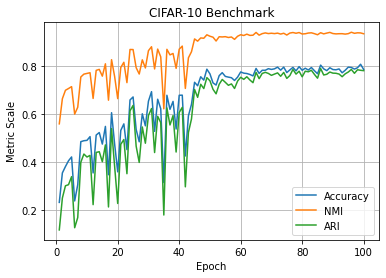

In [ ]:
#model.fit(dg,epochs=100)
plt.title('CIFAR-10 Benchmark')
plt.plot(log.savelog['Epoch'], log.savelog['ACC'], label='Accuracy')
plt.plot(log.savelog['Epoch'], log.savelog['NMI'], label='NMI')
plt.plot(log.savelog['Epoch'], log.savelog['ARI'], label='ARI')
plt.xlabel('Epoch')
plt.ylabel('Metric Scale')
plt.grid()
plt.legend()
plt.savefig('writer_identification.png', dpi=300)

In [ ]:
model.save('writer_identification')
temp_model = tf.keras.models.load_model('/content/drive/MyDrive/saved model/writer_identification')

In [ ]:
temp_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 3)            17650243    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 3)            0           model[0][0]                

In [ ]:
count=0
for layer in model.layers:
    print("Input shape: "+str(layer.input_shape)+". Output shape: "+str(layer.output_shape))
    print(count)
    count = count+1

Input shape: [(None, 60, 120, 1)]. Output shape: [(None, 60, 120, 1)]
0
Input shape: [(None, 60, 120, 1)]. Output shape: [(None, 60, 120, 1)]
1
Input shape: (None, 60, 120, 1). Output shape: (None, 3)
2
Input shape: [(None, 3), (None, 3)]. Output shape: (None, 3)
3
Input shape: (None, 3). Output shape: (None, 1)
4
Input shape: (None, 1). Output shape: (None, 1)
5


In [ ]:
print(x_val.shape)
kmeans = KMeans(n_clusters=len(np.unique(y_val)), n_jobs=-1, n_init=10)
AE = model.layers[2]
outs = AE.predict(x_val)
y_pred = kmeans.fit_predict(outs)
acc = accuracy(y_val, y_pred)
nmi = normalized_mutual_info_score(y_val, y_pred)
ari = adjusted_rand_score(y_val, y_pred)
print(acc,nmi,ari)

(2716, 60, 120, 1)
0.13807069219440354 0.12497823244276093 0.02920903918723011


(60, 120, 1) 3


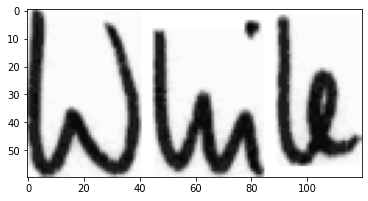

In [ ]:
x = x_val[5]
y = y_val[5]
print(x.shape,y)
plt.imshow(x[...,0],cmap='gray')
plt.show()

In [ ]:
x = x[np.newaxis,:,:,:]
out = AE.predict(x)
y_pre = kmeans.predict(out)
y_pre

array([1], dtype=int32)

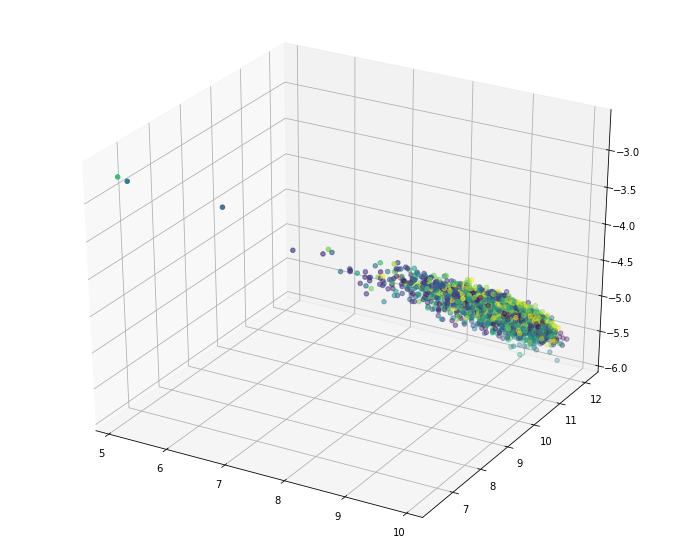

In [ ]:
def plot_label_clusters(AE, data, labels):
    # display a 2D plot of the digit classes in the latent space
    x1= AE.predict(data)
    #ax = plt.axes(projection ="3d")
    fig=plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x1[:, 0], x1[:, 1],x1[:,2] ,c=labels)
    #plt.colorbar()
    # plt.xlabel("z[0]")
    # plt.ylabel("z[1]")
    # plt.zlabel("z[2]")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(AE, x_val,y_val)